   # Pip Benjamin PHAS0102 Assignment 1

## Part 1

In this Jupyter Notebook we simulate a discrete diffusion process on a two dimensional grid with points $(i, j)$, $i, j = 0, \dots, N+1$. Starting with function values $u_0(i, j)$, we use the following recurrence relation:

$$
u_{n+1}(i, j) = \frac{1}{4}\left[u_n(i+1, j) + u_n(i-1, j) + u_n(i, j+1) + u_n(i, j-1)\right],~i,j=1,\dots, N
$$

This function assigns the value of a point on the grid as the average value of its adjacent points. We set up the function in order for the boundary values to remain constant, i.e.

$$
u_n(0, j) = u_0(0, j),\quad u_n(i, 0) = u_0(i, 0), \quad u_n(N + 1, j) = u_0(N + 1, j), \quad u_n(i, N + 1) = u_0(i, N + 1)
$$

Firstly we import all necessary modules used throughout the assignment.

In [1]:
import numpy as np
import numba 
import matplotlib.pyplot as plt 
from numba import njit, prange
from matplotlib import animation
from IPython.display import HTML

Below we define a method to perform the diffusion iteration on an n-dimensional numpy array. For the purposes of this assignment we will use only square 2-dimensional arrays. The below takes as input an (N+2) by (N+2) numpy array, this allows us to run `for` loops iterating over $(i, j)$ from $i, j = 1$ to $i, j = N+1$, leaving border values at $i, j = 0, N+2$ which are not affected by the diffusion process. The order of the for loops in the below has been chosen to reflect Numpy's use of C-style array ordering.

In [2]:
def diffusion_iteration(un):
    """
    Perform one diffusion step for all given grid points.
    
    Parameters
    ----------
    un : numpy.ndarray
        Numpy array of type `float64` and dimension (N + 2, N + 2) that stores the
        function values at step n.
        
    This function returns a Numpy array of dimension (N + 2, N + 2) of type `float64`
    that contains the function values after performing one step of the above diffusion
    iteration.
    """
    N=un[0].size-2
    #initialise iterated array
    un_plus1=np.zeros((N+2,N+2))
    
    for i in range(1,N+1):
        for j in range(1,N+1):
            un_plus1[i,j] = (1/4)*(un[i+1, j] + un[i-1, j] + un[i, j+1] + un[i, j-1])
          
   
    return un_plus1

We now define a timer to record the time taken for a single iteration of our diffusion process. This timer has been taken from the PHAS0102 lecture notes.

In [3]:
import time

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

We can define a method to record and display the time taken by our difussion process function for one iteration at various values of $N$. The below generates a random N-sized 2-dimensional array for values of $N$ we can choose, and records the time taken by our function to carry out a single iteration. The method then plots the time taken in seconds against $N$. Since the complexity/ number of operations carried out varies with $N^2$, we expect to see a quadratic relationship between the runtime and array dimension $N$. 

In [4]:
def single_it_benchmark(it_func, datapoints, Nmin, Nmax):
    """
    Perform a benachmarking task for increasing dimensions of N for the given recurrence relation.
    
    Parameters
    ----------
    it_func : function
        Function to run the benchmarking task over
    datapoints : int
        The number of benchmarking data points to generate
    Nmin : int
        Minimum dimension to consider
    Nmas : int
        Maximum dimension to consider
        
    This function generates a random numpy array and plots the time taken for one iteration of the recurrence relation 
    using a given iterating function, for dimension values between Nmin and Nmax.
    """
    
    #initialise arrays of dimension and time values, inclusive of final Nmax value
    N_array=np.linspace(Nmin, Nmax, datapoints, endpoint=True,).astype(int)
    time_array=np.empty(datapoints)
    
    counter=0
    for N in N_array:
        
        #random ndarray generated with dimension (N+2)(N+2)
        u0 = np.random.rand(N+2,N+2).astype('float64')
        
        #time how long one iteration takes on this ndarray
        with Timer() as t: 
            un=it_func(u0)
        time_elapsed=t.interval
        
        #add time to array
        time_array[counter]=time_elapsed
        counter+=1
        
    plt.figure()
    plt.plot(N_array, time_array)
    plt.title('Iteration time vs dimension $N$ for '+ it_func.__name__)
    plt.xlabel('N')
    plt.ylabel('Time/s')
    plt.grid()

The below confirms that the relationship between time and $N$ is approximately quadratic.

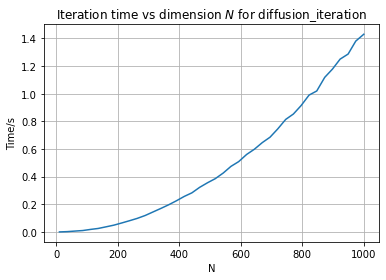

In [5]:
single_it_benchmark(diffusion_iteration, 40, 10 ,1000)

## Part 2

### Serial Numba

The diffusion process function defined above can be altered using numpy to improve run speed. Using the `@njit` decorator we can bypass the Python interpreter and use Numba's Just-In-Time compilation to low level machine code. Here we see the speed benefit achieved by simply using the `@njit` decorator to create a serial numba implementation of our diffusion process.

In [6]:
@njit
def diffusion_iteration_numba_nopara(un):
    """
    Perform one diffusion step for all given grid points, using the njit keyword to just-in-time compile into fast
    executable code.
    
    Parameters
    ----------
    un : numpy.ndarray
        Numpy array of type `float64` and dimension (N + 2, N + 2) that stores the
        function values at step n.
        
    This function returns a Numpy array of dimension (N + 2, N + 2) of type `float64`
    that contains the function values after performing one step of the above diffusion
    iteration.
    """
    N=un[0].size-2
    un_plus1=np.zeros((N+2,N+2))
    
    for i in range(1,N+1):
        for j in range(1,N+1):
            un_plus1[i,j] = (1/4)*(un[i+1, j] + un[i-1, j] + un[i, j+1] + un[i, j-1])
          
   
    return un_plus1



In the below we demonstrate the remarkable effect numba can have on the speed of array calculations. At $N=1000$ we see a speed increase of two orders of magnitude compared to the non-numba implemented function. We first call the serial numba function below before parsing it to the benchmarking method, in order to account for the time taken when numba is initially run.

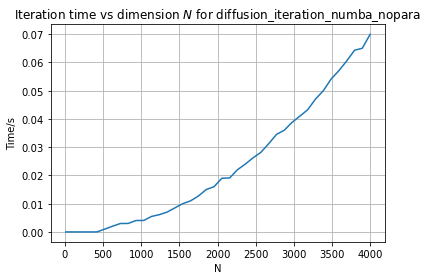

In [7]:
N=2
u0 = np.random.rand(N+2,N+2).astype('float64')
diffusion_iteration_numba_nopara(u0)

single_it_benchmark(diffusion_iteration_numba_nopara, 40, 10 ,4000)

### Parallel Numba

We now investigate the effect of a parallelised numba implementation of our function on the computation speed. Here our parallelisation is as simple as changing the `range` function in our for loops to the parallelised `prange.` On my laptop, with six cores, theory would suggest that with a parallel implentation of our function we should expect an assosciated speed-up by a factor 6. In reality, this is not the case, as shown by the benchmarking (at least on my machine) where only a modest speed-up of around 20% can be seen. This modest speed-up could be due to the very simplistic `for` loops being used in our function.

In [8]:
@njit(['float64[:,:](float64[:,:])'], parallel=True)
def diffusion_iteration_numba_para(un):
    """
    Perform one diffusion step for all given grid points, using parallelisation and 
    the njit keyword to just-in-time compile into fast executable code.
    
    Parameters
    ----------
    un : numpy.ndarray
        Numpy array of type `float64` and dimension (N + 2, N + 2) that stores the
        function values at step n.
        
    This function returns a Numpy array of dimension (N + 2, N + 2) of type `float64`
    that contains the function values after performing one step of the above diffusion
    iteration.
    """
    N=un[0].size-2
    un_plus1=np.zeros((N+2,N+2))
    
    for i in prange(1,N+1):
        for j in prange(1,N+1):
            un_plus1[i,j] = (1/4)*(un[i+1, j] + un[i-1, j] + un[i, j+1] + un[i, j-1])
          
   
    return un_plus1

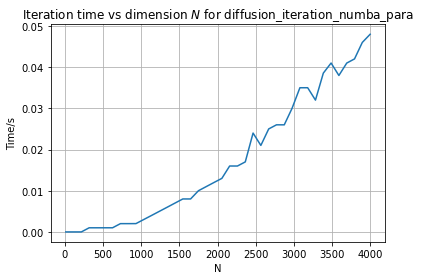

In [9]:
diffusion_iteration_numba_para(u0)
single_it_benchmark(diffusion_iteration_numba_para, 40, 10 ,4000)

## Part 3 / Advanced Problem

In the final part of this notebook we create an animation representing multiple iterations of our diffusion process function, and develop a method to keep specific grid points $(i, j)$ constant over multiple iterations. Below we define a new iterating function which takes into account indices which are to be kept constant.

In [10]:
@njit( parallel=True)
def diffusion_iteration_numba_para_index(un, constant_indices):
    """
    Perform one diffusion step for all given grid points.
    
    Parameters
    ----------
    un : numpy.ndarray
        Numpy array of type `float64` and dimension (N + 2, N + 2) that stores the
        function values at step n.
    constant_indices : numpy.ndarray
        Numpy array of type `int8` representing points i,j in un to be kept constant.
        
    This function returns a Numpy array of dimension (N + 2, N + 2) of type `float64`
    that contains the function values after performing one step of the above diffusion
    iteration, whilst keeping specified points constant.
    """  
    N=un[0].size-2
    #initialise iterated array
    un_plus1=np.zeros((N+2,N+2))
    
    for i in prange(1,N+1):
        for j in prange(1,N+1):
            un_plus1[i,j] = (1/4)*(un[i+1, j] + un[i-1, j] + un[i, j+1] + un[i, j-1])
            
    
    #find points to be kept constant and revert them back to the input array 'un'
    for n in prange(0, len(constant_indices)):
        i,j = constant_indices[n,0] , constant_indices[n,1]
        un_plus1[i,j] = un[i,j]    

    return un_plus1

We next define a function to perform a given number of iterations of our diffusion process, returning the array $u_n$ where $n$ is the number of iterations performed. The below method to produce an animation requires that each frame representing each iteration $u_n$ be produced from scratch, iterating `n` times over our diffusion function for each subsequent frame. This is clearly far from ideal as it requires a far greater number of computations than simply producing each frame as an iteration of the previous frame. However, I found that the suggested `animation.FuncAnimation` function requires a function as an argument, in our case `animate,` which takes its own arguments (i.e. `u_0`) which cannot be updated within the `animate` function loop for iteration over subsequent frames by reassigning the variable such that `u0 = un`. This meant that `animate` had to take `u_0` as an argument which could be iterated on `n=frames` times for each frame in the animation.

In [11]:
def multi_iteration(n,func, u0,constant_indices):
    """
    Perform a specified number of diffusion step for all given grid points, taking into account indices which are
    required to be kept constant.
    
    Parameters
    ----------
    n : int8
        Number of iterations to be performed
    func : function
        Diffusion process function to be iterated over.
    u0 : numpy.ndarray
        Numpy array of type `float64` and dimension (N + 2, N + 2) that contains the input data.
    constant_indices : nunmpy.ndarray
        Numpy array of type `int8` representing points i,j in un to be kept constant.
        
    This function returns a Numpy array of dimension (N + 2, N + 2) of type `float64`
    that contains the function values after performing a specified number of steps of the above diffusion
    iteration, whilst keeping specified points constant.
    """
    N=u0[0].size-2
    #initialise output array
    un=np.zeros((N+2,N+2))
    
    if(n==0):
        return u0
    
    #iterate the function for a given number of steps n, return final array
    else:
        for it in range(0,n):
            un= func(u0,constant_indices)
            u0=un
        return un

Below we define the required nice initial distribution of $u_0$ values. I have chosen a distribution with $u_{0}(i, j)$ scaling as $u_{0}(i, j)^5$ with increasing $i,j$. An example for $N=5$ is shown in the output below. Using $N=25$ with this distribution gives us a pleasing looking diffusion from a central point, here violet represents small numbers, red represents large numbers.

[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   1.   1.   1.   1.   0.]
 [  0.   1.  32.  32.  32.   1.   0.]
 [  0.   1.  32. 243.  32.   1.   0.]
 [  0.   1.  32.  32.  32.   1.   0.]
 [  0.   1.   1.   1.   1.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.]]


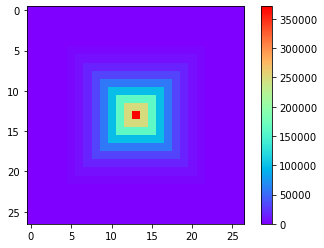

In [12]:
#print our nice initial distribution for N=5
N=5
u0=np.zeros((N+2,N+2))
for n in range (1,int(N/2 +1/2)+1):
    u0[n:(N+1)-(n-1), n:(N+1)-(n-1)]=n*n*n*n*n
print(u0)
  
    
#figure for animation to be presented on
fig = plt.figure()

#dummy array of constant indices 
S=np.asarray([[0,0],[0,1]])

#nice initial distribution for animation
N=25
u0=np.zeros((N+2,N+2))
for n in range (1,int(N/2 +1/2)+1):
    u0[n:(N+1)-(n-1), n:(N+1)-(n-1)]=n*n*n*n*n
    
#define an image with a colorbar
im=plt.imshow(u0, cmap='rainbow')
cb = fig.colorbar(im)

#produce each frame
def animate(frame,func,u0,constant_indices):

    un= multi_iteration(frame,func,u0,constant_indices)
    im= plt.imshow(un, cmap='rainbow')
    
    return [im]

#produce animation
anim=animation.FuncAnimation(fig, animate,fargs=(diffusion_iteration_numba_para_index,u0,S, ), frames=70, interval=100)
#display animation
HTML(anim.to_jshtml())



Finally, we implement an index set $S = \{(i_0, j_0), (i_1, j_1), \dots \}$ of interior indices at which we are keeping the interior iteration values constant, such that we set $u_n(i, j) = u_0(i, j)$ for $(i, j)\in S$. To do this we define a $m\times2$ numpy array where $m$ is the number of index points we wish to set as constants. This array is parsed subsequently to `animation.FuncAnimation`, `animate`, `multi_iteration`, and finally `diffusion_iteration_numba_para_index`, where the values of the points included in $S$ in the $u_{n+1}$ array are set equal to those points in $u_n$. 

Below we create another animation with a set of constant index values. We can see these have a dramatic effect on the 'outward' diffusion seen before, and causes the small region of comparatively very large numbers to shrink significantly, with their diffusive effect blocked by constant index values.  

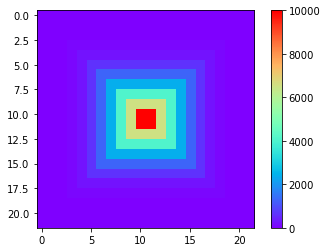

In [13]:
#define nice initial distribution
N=20
u0= np.zeros((N+2,N+2))
for n in range (1,int(N/2 +1/2)+1):
    u0[n:(N+1)-(n-1), n:(N+1)-(n-1)]=n*n*n*n

#array of constant indices
S=np.asarray([[1,2],[3,4],[5,10], [13,12],[12,13], [10,9], [16,9],[22,20],[6,5]])

#new figure
fig2 = plt.figure()

#define an image with a colorbar
im=plt.imshow(u0, cmap='rainbow')
cb = fig2.colorbar(im)

#produce animation
anim=animation.FuncAnimation(fig2, animate,frames=50,fargs =(diffusion_iteration_numba_para_index,u0,S ), interval=100)
#display animation
HTML(anim.to_jshtml())
